In [3]:
import pandas as pd 
import geopandas as gpd
from scipy.io import mmread
import networkx as nx
import numpy as np
import matplotlib.pyplot as plt 

# Toronto 
## Cases

In [17]:
df_tor = pd.read_csv("Data/CasesToronto.csv")
#df_tor["Neighbourhood Name"].value_counts()
#df_tor.Outcome.value_counts()
df_tor.head()

,_id,Assigned_ID,Outbreak Associated,Age Group,Neighbourhood Name,FSA,Source of Infection,Classification,Episode Date,Reported Date,Client Gender,Outcome,Currently Hospitalized,Currently in ICU,Currently Intubated,Ever Hospitalized,Ever in ICU,Ever Intubated
0,126705,1,Sporadic,50 to 59 Years,Willowdale East,M2N,Travel,CONFIRMED,2020-01-22,2020-01-23,FEMALE,RESOLVED,No,No,No,No,No,No
1,126706,2,Sporadic,50 to 59 Years,Willowdale East,M2N,Travel,CONFIRMED,2020-01-21,2020-01-23,MALE,RESOLVED,No,No,No,Yes,No,No
2,126707,3,Sporadic,20 to 29 Years,Parkwoods-Donalda,M3A,Travel,CONFIRMED,2020-02-05,2020-02-21,FEMALE,RESOLVED,No,No,No,No,No,No
3,126708,4,Sporadic,60 to 69 Years,Church-Yonge Corridor,M4W,Travel,CONFIRMED,2020-02-16,2020-02-25,FEMALE,RESOLVED,No,No,No,No,No,No
4,126709,5,Sporadic,60 to 69 Years,Church-Yonge Corridor,M4W,Travel,CONFIRMED,2020-02-20,2020-02-26,MALE,RESOLVED,No,No,No,No,No,No


## Traffic

In [4]:
traffic_toronto = gpd.read_file("Data/2019-04-01-Toronto.geojson")
traffic_toronto = traffic_toronto.iloc[1:]

In [5]:
traffic_toronto = traffic_toronto.drop(["jobName", "creationTime", "userPreference", "dateRanges", "timeSets", "networkName", "zoneId", "probeSource", "segmentId"], axis = 1)

In [20]:
traffic_toronto.head()

,newSegmentId,speedLimit,frc,streetName,distance,segmentTimeResults,geometry
1,-0000434f-5000-0400-0000-000000a7daf6,60.0,3.0,Steeles Ave W,46.29,"[ { ""timeSet"": 2, ""dateRange"": 1, ""harmonicAve...","LINESTRING (-79.52444 43.77480, -79.52388 43.7..."
2,-0000434f-5000-0400-0000-000000a7daff,60.0,3.0,Steeles Ave W,59.18,"[ { ""timeSet"": 2, ""dateRange"": 1, ""harmonicAve...","LINESTRING (-79.46387 43.78851, -79.46316 43.7..."
3,-0000434f-5000-0400-0000-000000a7db02,60.0,4.0,Steeles Ave E,52.77,"[ { ""timeSet"": 2, ""dateRange"": 1, ""harmonicAve...","LINESTRING (-79.30009 43.82530, -79.30072 43.8..."
4,-0000434f-5000-0400-0000-000000a7db0d,60.0,3.0,Steeles Ave W,36.22,"[ { ""timeSet"": 2, ""dateRange"": 1, ""harmonicAve...","LINESTRING (-79.53222 43.77324, -79.53211 43.7..."
5,-0000434f-5000-0400-0000-000000a7db18,60.0,3.0,Steeles Ave W,49.58,"[ { ""timeSet"": 2, ""dateRange"": 1, ""harmonicAve...","LINESTRING (-79.63014 43.75182, -79.62955 43.7..."


In [23]:
traffic_toronto.segmentTimeResults[1] + traffic_toronto.segmentTimeResults[2]

'[ { "timeSet": 2, "dateRange": 1, "harmonicAverageSpeed": 16.820000, "medianSpeed": 31.200000, "averageSpeed": 32.780000, "standardDeviationSpeed": 19.390000, "travelTimeStandardDeviation": 15.410000, "sampleSize": 1772, "averageTravelTime": 9.910000, "medianTravelTime": 5.340000, "travelTimeRatio": 1.000000, "speedPercentiles": [ 5, 7, 9, 14, 18, 21, 24, 28, 29, 31, 32, 32, 37, 47, 50, 54, 57, 57, 64 ] } ][ { "timeSet": 2, "dateRange": 1, "harmonicAverageSpeed": 29.980000, "medianSpeed": 48.200000, "averageSpeed": 48.580000, "standardDeviationSpeed": 21.810000, "travelTimeStandardDeviation": 19.940000, "sampleSize": 2146, "averageTravelTime": 7.110000, "medianTravelTime": 4.420000, "travelTimeRatio": 1.000000, "speedPercentiles": [ 13, 19, 25, 30, 34, 38, 40, 43, 45, 48, 51, 53, 55, 59, 62, 66, 73, 83, 86 ] } ]'

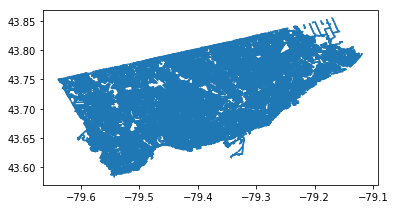

In [8]:
traffic_toronto.plot()

## Neighbourhood Profiles

In [25]:
DF_neighbourhoods_info = pd.read_csv("Data/neighbourhood-profiles-2016-csv.csv")
DF_neighbourhoods_info.head()

,_id,Category,Topic,Data Source,Characteristic,City of Toronto,Agincourt North,Agincourt South-Malvern West,Alderwood,Annex,...,Willowdale West,Willowridge-Martingrove-Richview,Woburn,Woodbine Corridor,Woodbine-Lumsden,Wychwood,Yonge-Eglinton,Yonge-St.Clair,York University Heights,Yorkdale-Glen Park
0,1,Neighbourhood Information,Neighbourhood Information,City of Toronto,Neighbourhood Number,NaN,129,128,20,95,...,37,7,137,64,60,94,100,97,27,31
1,2,Neighbourhood Information,Neighbourhood Information,City of Toronto,TSNS2020 Designation,NaN,No Designation,No Designation,No Designation,No Designation,...,No Designation,No Designation,NIA,No Designation,No Designation,No Designation,No Designation,No Designation,NIA,Emerging Neighbourhood
2,3,Population,Population and dwellings,Census Profile 98-316-X2016001,"Population, 2016","2,731,571","29,113","23,757","12,054","30,526",...,"16,936","22,156","53,485","12,541","7,865","14,349","11,817","12,528","27,593","14,804"
3,4,Population,Population and dwellings,Census Profile 98-316-X2016001,"Population, 2011","2,615,060","30,279","21,988","11,904","29,177",...,"15,004","21,343","53,350","11,703","7,826","13,986","10,578","11,652","27,713","14,687"
4,5,Population,Population and dwellings,Census Profile 98-316-X2016001,Population Change 2011-2016,4.50%,-3.90%,8.00%,1.30%,4.60%,...,12.90%,3.80%,0.30%,7.20%,0.50%,2.60%,11.70%,7.50%,-0.40%,0.80%


In [26]:
DF_neighbourhoods_shape = gpd.read_file("Data/toronto_neigh.geojson")

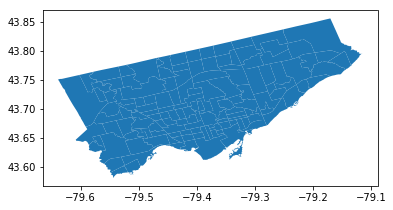

In [28]:
DF_neighbourhoods_shape.plot()

## OSM Data

In [9]:
# http://polygons.openstreetmap.fr/index.py?id=43992 , polygon creation from osm id (turin = 43992)
boundary_toronto = gpd.read_file("Data/Toronto.geojson")
#bbox = boundary_turin.envelope 
#df_bbox = gpd.GeoDataFrame(gpd.GeoSeries(bbox), columns = ["geometry"])
#intersections = gpd.overlay(df_bbox, DF_roads_turin, how = "intersection")

In [10]:
# bbox = (7.25,44.8,8.1,45.4)
DF_roads_toronto = gpd.read_file("Data/ontario-latest-free.shp/gis_osm_roads_free_1.shp", bbox = boundary_toronto)
DF_buildings_toronto = gpd.read_file("Data/ontario-latest-free.shp/gis_osm_buildings_a_free_1.shp", bbox = boundary_toronto)
# ferrovie di treni e tram
DF_railway_toronto = gpd.read_file("Data/ontario-latest-free.shp/gis_osm_railways_free_1.shp", bbox = boundary_toronto)
#parcheggi, anche multipiano
DF_parking_toronto = gpd.read_file("Data/ontario-latest-free.shp/gis_osm_traffic_a_free_1.shp", bbox = boundary_toronto)

# just in case
DF_churches_toronto = gpd.read_file("Data/ontario-latest-free.shp/gis_osm_pofw_a_free_1.shp", bbox = boundary_toronto)
# ospedali, parchi, teatri 
DF_public_places_toronto = gpd.read_file("Data/ontario-latest-free.shp/gis_osm_pois_a_free_1.shp", bbox = boundary_toronto)
# DF_public_places_toronto[DF_public_places_toronto.fclass == "hospital"]
# stazioni ferroviarie, fermate bus, tram, traghetto (lol?), taxi 
DF_transport_toronto = gpd.read_file("Data/ontario-latest-free.shp/gis_osm_transport_a_free_1.shp", bbox = boundary_toronto)

In [11]:
DF_roads_toronto.to_file("Data/Toronto_final/Roads_Toronto.shp")
DF_buildings_toronto.to_file("Data/Toronto_final/Buildings_Toronto.shp")

In [12]:
DF_public_places_toronto[DF_public_places_toronto.fclass == "hospital"].to_file("Data/Toronto_final/Hospitals_toronto.shp")

In [13]:
print(DF_roads_toronto.shape)
print(DF_buildings_toronto.shape)
print(DF_railway_toronto.shape)
print(DF_parking_toronto.shape)

(134309, 11)
(504997, 6)
(4256, 8)
(15743, 5)


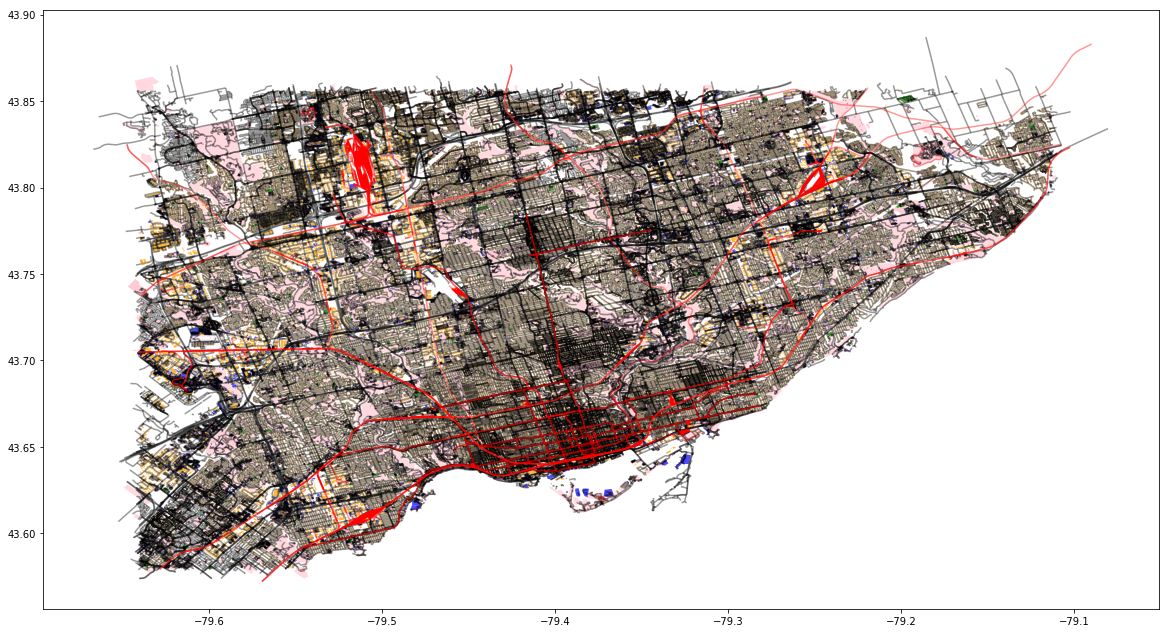

In [16]:
# matplotlib qt permette di avere una figura interattiva
# %matplotlib qt

#%matplotlib inline

fig, ax = plt.subplots(figsize=(20, 20))
DF_roads_toronto.plot(ax = ax, alpha = 0.4, color = "black")
DF_buildings_toronto.plot(ax = ax, alpha = 0.8, color = "orange")
DF_public_places_toronto.plot(ax = ax , alpha = 0.6, color = "pink")
DF_parking_toronto.plot(ax = ax, alpha = 0.7, color = "blue")
DF_churches_toronto.plot(ax = ax, alpha = 0.7, color = "green")
DF_railway_toronto.plot(ax = ax, alpha = 0.4, color = "red")
fig.savefig("Data/Toronto_Net.png", dpi = 1200)
#ax.set_xlim([7.56, 7.78])
#ax.set_ylim([45, 45.155])